In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

df_train = pd.read_csv(f"{path}/train.csv")
df_test = pd.read_csv(f"{path}/test.csv")

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/teejmahal20/airline-passenger-satisfaction/versions/1


Target Imbalance:
satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64


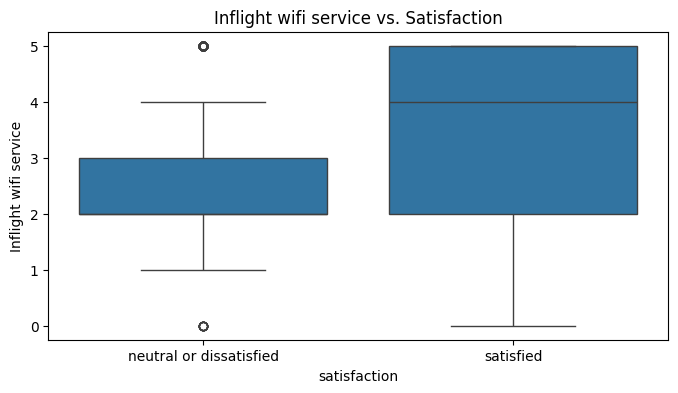

In [5]:


# Target Imbalance Check
print("Target Imbalance:")
print(df_train['satisfaction'].value_counts(normalize=True))

# Service Ratings vs. Satisfaction (Box plots for key ratings)
service_ratings = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 
                   'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 
                   'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 
                   'Checkin service', 'Inflight service', 'Cleanliness']

for rating in service_ratings[:1]:  
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_train, x='satisfaction', y=rating)
    plt.title(f'{rating} vs. Satisfaction')
    plt.show()



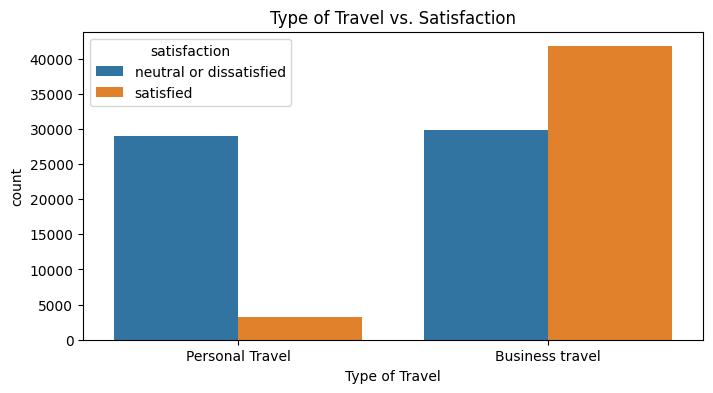

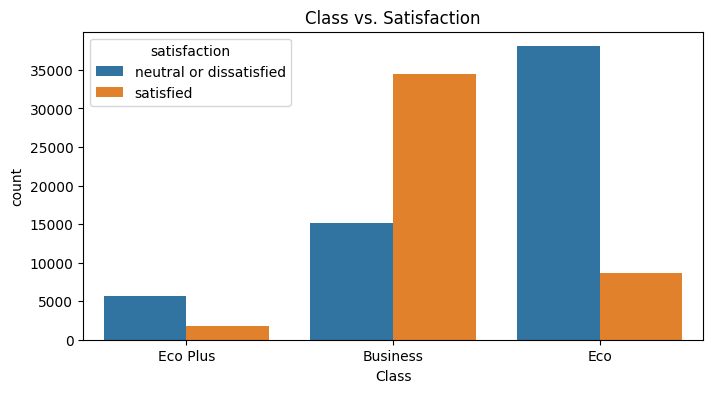

In [6]:
# Travel Details vs. Satisfaction
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='Type of Travel', hue='satisfaction')
plt.title('Type of Travel vs. Satisfaction')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='Class', hue='satisfaction')
plt.title('Class vs. Satisfaction')
plt.show()



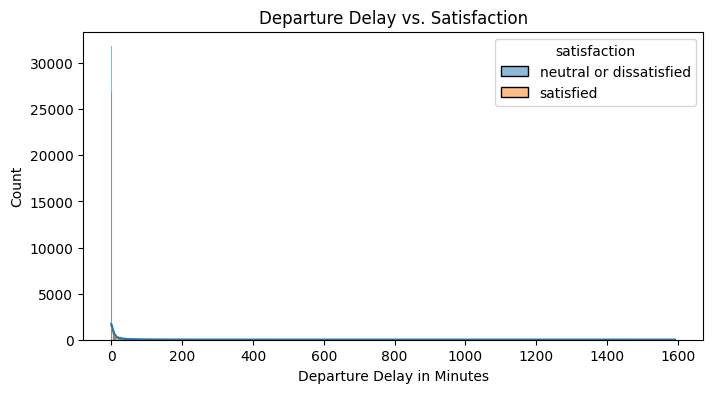

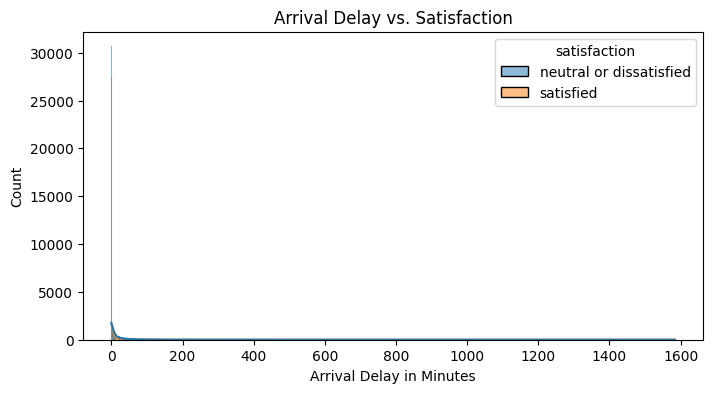

In [7]:
# Operational Metrics vs. Satisfaction
plt.figure(figsize=(8, 4))
sns.histplot(data=df_train, x='Departure Delay in Minutes', hue='satisfaction', kde=True)
plt.title('Departure Delay vs. Satisfaction')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data=df_train, x='Arrival Delay in Minutes', hue='satisfaction', kde=True)
plt.title('Arrival Delay vs. Satisfaction')
plt.show()



In [ ]:
# Correlation Matrix for Service Ratings
corr_matrix = df_train[service_ratings].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Service Ratings')
plt.show()